# Detect particles in BSE images and EBSD intensity maps

Håkon Wiik Ånes (hakon.w.anes@ntnu.no)

In [1]:
# Switch to interactive Matplotlib backend (e.g. qt5) for control point determination
%matplotlib inline

from datetime import date
import importlib_metadata
import os

from mapregions import MapRegions
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import skimage.color as skc
import skimage.filters as skf
from skimage.segmentation import watershed


# Directories
dset_no = 1
dir_data = f"/home/hakon/phd/data/p/prover/300c/{dset_no}"
dir_bse = os.path.join(dir_data, "bse")
dir_imreg = os.path.join(dir_data, "imreg")
dir_kp = os.path.join(dir_data, "kp")

# Remove zero-regions resulting from stitching of BSE images
crop_bse_full = {
    1: (slice(1,  3749), slice(124, 5576)),
    2: (slice(16, 3837), slice(137, 5798)),
    3: (slice(25, 3949), slice(50,  5289))
}

# Matplotlib
plt.rcParams.update({"axes.grid": False, "figure.figsize": (15, 5), "font.size": 15})
savefig_kw = dict(bbox_inches="tight", pad_inches=0, dpi=300)

print("Run date: ", date.today())
print("\nSoftware versions\n-----------------")
for pkg in ["mapregions", "matplotlib", "numpy", "orix", "scipy", "scikit-image"]:
    if pkg == "numpy":
        ver = np.__version__
    else:
        ver = importlib_metadata.version(pkg)
    print(pkg, ":", ver)

Run date:  2022-07-24

Software versions
-----------------
mapregions : 0.1.dev0
matplotlib : 3.5.2
numpy : 1.22.4
orix : 0.9.0.post0
scipy : 1.8.1
scikit-image : 0.19.3


In [2]:
#data_type = "ebsd"
data_type = "bse"
#data_type = "bse_full"

In [3]:
if data_type == "ebsd":
    mask = np.load(os.path.join(dir_imreg, "mask_ebsd_correct.npy"))
    gauss_window_size = 5
    img_orig = plt.imread(os.path.join(dir_imreg, "ebsd_correct.png"))
    img2 = skc.rgb2gray(img_orig[..., :3])
else:
    if data_type == "bse":
        img_orig = plt.imread(os.path.join(dir_imreg, "bse_rescaled.png"))
        img2 = skc.rgb2gray(img_orig[..., :3])
    else:  # bse_full
        img2 = plt.imread(os.path.join(dir_bse, "4500x_cropped2_fused.png"))[crop_bse_full[sample]]
    mask = np.ones(img2.shape, dtype=bool)
    gauss_window_size = 20

## Detection steps

### 1. Intensity processing

In [4]:
# Flat field by subtracting long-range intensity variations
sigma = int(np.ceil(max(img2.shape) / gauss_window_size))
blur = ndimage.gaussian_filter(img2, sigma=sigma)
img3 = img2 - blur

In [5]:
# Normalize to enable thresholding independent of absolute intensities
img = img3 - img3[mask].mean()
img = img / np.linalg.norm(img[mask])

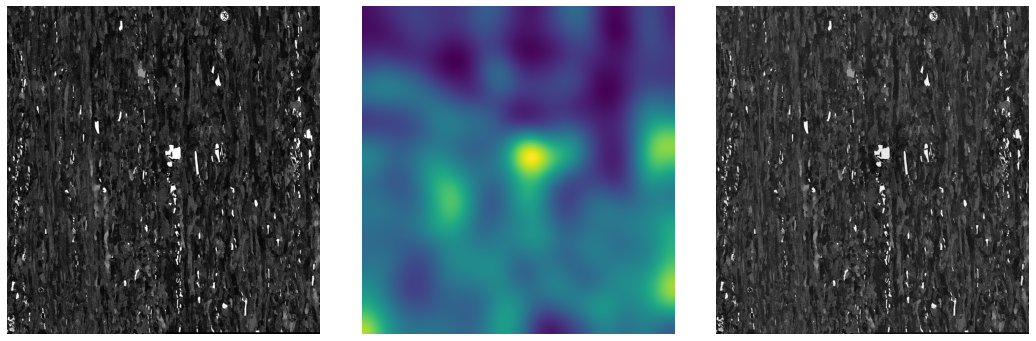

In [6]:
# Inspect intensity processing
fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True)
ax[0].imshow(img2, cmap="gray")
ax[1].imshow(blur)
ax[2].imshow(img, cmap="gray")
for a in ax:
    a.axis("off")
fig.tight_layout()

### 2. Generate elevation map

In [7]:
# Elevation map
elevation_map = skf.sobel(img)

### 3. Determine markers for background and particles

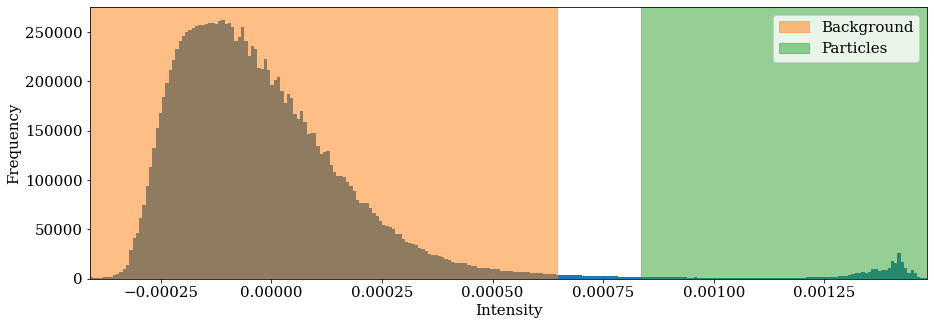

In [8]:
int_range = (img[mask].min(), img[mask].max())
diff = abs(np.diff(int_range)[0])

# Threshold for markers
threshold = skf.threshold_triangle(img[mask])
background = threshold + 0.15 * diff
particles = threshold + 0.25 * diff

# Intensity histogram
fig, ax = plt.subplots()
ax.hist(img[mask].ravel(), bins=255, range=int_range);
ax.set_xlabel("Intensity")
ax.set_ylabel("Frequency")
ax.set_xlim(int_range)
ax.axvspan(int_range[0], background, color="C1", alpha=0.5, label="Background")
ax.axvspan(particles, int_range[1], color="C2", alpha=0.5, label="Particles")
ax.legend();

### 4. Compute watershed and 5. remove holes within particles segmented from the watershed

In [9]:
# Generate sure markers of background and particles from the extreme parts of the
# intensity histogram
markers = np.zeros_like(img)
markers[img < background] = 1
markers[img > particles] = 2

# Compute the watershed transformation (computationally intensive)
segmentation = watershed(elevation_map, markers)

# Remove small holes with mathematical morphology
segmentation = ndimage.binary_fill_holes(segmentation - 1)

# Label particles
labeled_particles, n = ndimage.label(segmentation)
print(n)

# Inspect segmentation (useful to plot when optimizing processing and detection
# parameters)
#fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True)
#ax[0].imshow(img, cmap="gray")
#ax[1].imshow(markers)
#ax[2].imshow(img, cmap="gray")
#ax[2].contour(segmentation, colors="r", linewidths=0.5)
#for a in ax:
#    a.axis("off")
#fig.tight_layout(w_pad=0.5)

6152


### 6. Remove incorrectly detected particles

In [10]:
# Remove incorrectly detected particles
regions = MapRegions(
    label_map=labeled_particles,
    background_label=0,
    intensity_image=img,
)

mean_intensity = regions.mean_intensity
roundness = regions.roundness
solidity = regions.solidity

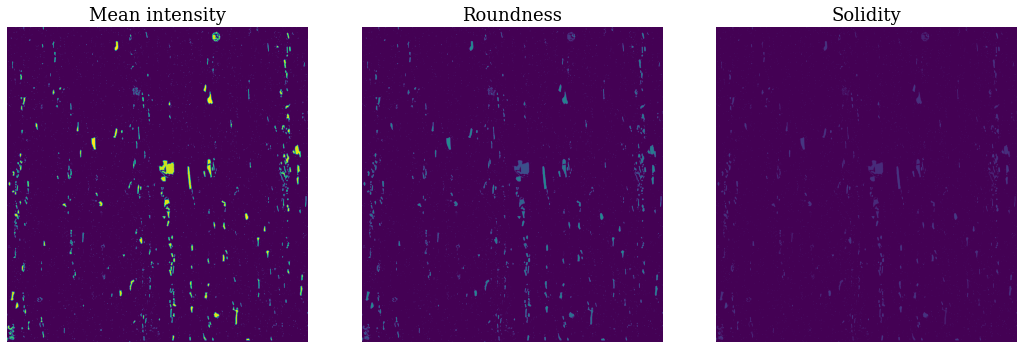

In [11]:
# Check spatial distribution of rejection properties
titles = ["Mean intensity", "Roundness", "Solidity"]
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharex=True, sharey=True)
ax0.imshow(regions.get_map_data(mean_intensity))
ax1.imshow(regions.get_map_data(roundness))
ax2.imshow(regions.get_map_data(solidity))
for i, ax in enumerate((ax0, ax1, ax2)):
    ax.set_title(titles[i])
    ax.axis("off")
fig.tight_layout()

In [12]:
# Check histograms of rejection properties

# Filter detected particles
threshold_mean_intensity = np.percentile(mean_intensity, 55)
threshold_roundness = np.percentile(roundness[roundness > 0], 25)
threshold_solidity = np.percentile(solidity[solidity > 0], 25)
print(threshold_mean_intensity, threshold_roundness, threshold_solidity)

#titles = ["Mean intensity", "Roundness", "Solidity"]
# Inspect thresholds
#fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(9, 3))
#ax0.hist(mean_intensity, bins=100);
#ax1.hist(roundness, bins=100);
#ax2.hist(solidity, bins=100);
#ax0.axvspan(threshold_mean_intensity, mean_intensity.max(), color="C1", alpha=0.5, label="Keep")
#ax1.axvspan(threshold_roundness, roundness.max(), color="C1", alpha=0.5, label="Keep")
#ax2.axvspan(threshold_solidity, solidity.max(), color="C1", alpha=0.5, label="Keep")
#for i, ax in enumerate((ax0, ax1, ax2)):
#    ax.set_xlabel(titles[i])
#    ax.set_ylabel("Frequency")
#    ax.legend()
#fig.tight_layout()

keep = (
    mean_intensity > threshold_mean_intensity,
    roundness == 0,
    roundness > threshold_roundness,
    solidity == 0,
    solidity > threshold_solidity,
)

# Reject some particles
regions2 = regions[np.logical_or.reduce(keep)]
print(regions2)

0.0008988510875497013 1.0 1.8333333333333333
MapRegions: 5906


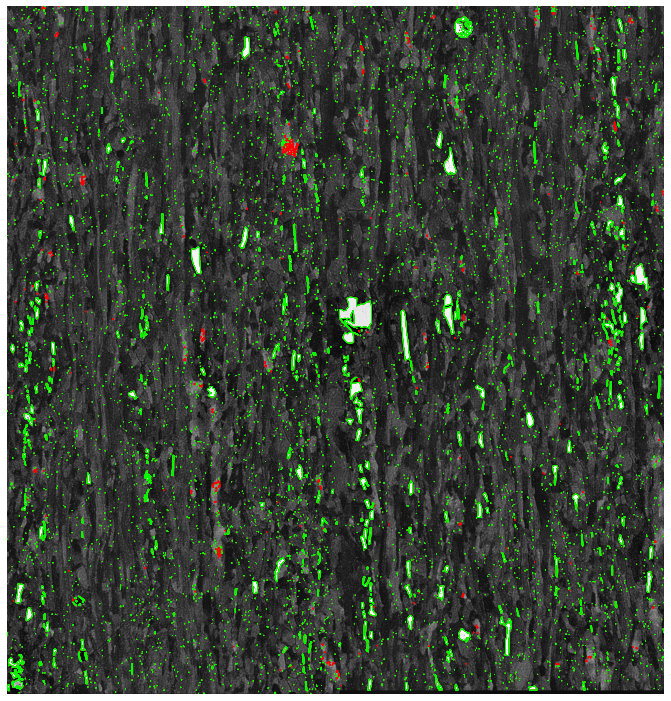

In [13]:
# Check plot of rejected particles
lw = plt.rcParams["lines.linewidth"]
plt.rcParams["lines.linewidth"] = 0.5

contour_kwds = dict(zorder=2)
fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(10, 10))
ax.imshow(regions.intensity_image, cmap="gray")
ax.contour(~regions.is_background_map, colors="red", **contour_kwds)
ax.contour(~regions2.is_background_map, colors="lime", **contour_kwds)
ax.axis("off")
fig.tight_layout()

plt.rcParams["lines.linewidth"] = lw

In [14]:
# Save labeled particles to file
if data_type == "ebsd":
    np.save(os.path.join(dir_imreg, "ebsd_labels_filled"), labeled_particles)
elif data_type == "bse":
    np.save(os.path.join(dir_imreg, "bse_labels_filled_filtered"), regions2.label_map)
else:  # bse_full
    np.save(os.path.join(dir_imreg, "bse_full_labels_filled_filtered"), regions2.label_map)